In [1]:
!pip install opencv-python pandas matplotlib ultralytics


Code to Collect Data

In [13]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tracker import Tracker

# Load YOLO model
model = YOLO('yolov8s.pt')

# Vehicle-related classes (as per YOLO)
vehicle_classes = ['car', 'motorcycle', 'bus', 'truck']
# Emergency vehicles (may be detected as truck/bus)
emergency_classes = ['Ambulance', 'Firetruck', 'police', 'truck', 'bus', 'police']

# Initialize tracker
tracker = Tracker()
count = 0

# Open video file
cap = cv2.VideoCapture('traffic_with_emergency.mp4')

# Dictionaries and lists for tracking
down = {}  # Vehicles crossing the red line
up = {}  # Vehicles crossing the blue line
counter_down = []  # IDs of vehicles that crossed the red line
counter_up = []  # IDs of vehicles that crossed the blue line
emergency_crossed_red = False  # Track if an emergency vehicle has crossed the red line
emergency_crossed_blue = False  # Track if an emergency vehicle has crossed the blue line

# Logs for graph plotting
time_intervals = []
vehicle_count_log = []
emergency_count_log = []
signal_change_log = []  # Log signal state (1 for green, 0 for red)

# Line positions
red_line_y = 198
blue_line_y = 400
offset = 7

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    count += 1
    frame = cv2.resize(frame, (1020, 500))

    # Perform object detection
    results = model.predict(frame)
    detections = results[0].boxes.data.detach().cpu().numpy()
    px = pd.DataFrame(detections).astype("float")

    detected_vehicles = []
    emergency_vehicle_detected = 0
    
    # Process detections
    for _, row in px.iterrows():
        x1, y1, x2, y2, _, class_id = map(int, row[:6])
        vehicle_type = model.names[class_id]
        
        if vehicle_type in vehicle_classes or vehicle_type in emergency_classes:
            detected_vehicles.append([x1, y1, x2, y2, vehicle_type])
            if vehicle_type in emergency_classes:
                emergency_vehicle_detected += 1
    
    # Update tracker with detected vehicles
    bbox_id = tracker.update([box[:4] for box in detected_vehicles])
    
    # Process tracked vehicles
    for i, bbox in enumerate(bbox_id):
        x3, y3, x4, y4, obj_id = bbox
        cx = int((x3 + x4) / 2)
        cy = int((y3 + y4) / 2)
        
        # Red line logic
        if red_line_y - offset < cy < red_line_y + offset:
            down[obj_id] = cy   
        
        if obj_id in down:
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.putText(frame, str(obj_id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
            counter_down.append(obj_id)
            if detected_vehicles[i][4] in emergency_classes:
                emergency_crossed_red = True
        
        # Blue line logic
        if blue_line_y - offset < cy < blue_line_y + offset:
            up[obj_id] = cy   
        
        if obj_id in up:
            cv2.circle(frame, (cx, cy), 4, (255, 0, 0), -1)
            cv2.putText(frame, str(obj_id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
            counter_up.append(obj_id)
            if detected_vehicles[i][4] in emergency_classes:
                emergency_crossed_blue = True
        
        # Display vehicle name on top
        vehicle_name = detected_vehicles[i][4]
        cv2.putText(frame, vehicle_name, (x3, y3 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # Logging data for graphs
    total_vehicles = len(set(counter_down))
    time_intervals.append(count)
    vehicle_count_log.append(total_vehicles)
    emergency_count_log.append(emergency_vehicle_detected)
    
    # Signal Logic: Green if emergency vehicle crossed red line, Red if it crossed blue line
    if emergency_crossed_red and not emergency_crossed_blue:
        signal_color = (0, 255, 0)  # Green
        signal_state = 1  # Green
    elif total_vehicles > 50:  # Additional condition: Green if vehicle count > 30
        signal_color = (0, 255, 0)  # Green
        signal_state = 1  # Green
    else:
        signal_color = (0, 0, 255)  # Red
        signal_state = 0  # Red
    
    # Log signal state
    signal_change_log.append(signal_state)

    # Draw signal at the center
    cv2.rectangle(frame, (470, 20), (520, 70), signal_color, -1)
    
    # Draw red line
    cv2.line(frame, (172, red_line_y), (774, red_line_y), (0, 0, 255), 3)
    cv2.putText(frame, 'Red Line', (172, red_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Draw blue line
    cv2.line(frame, (172, blue_line_y), (774, blue_line_y), (255, 0, 0), 3)
    cv2.putText(frame, 'Blue Line', (172, blue_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Display vehicle count
    cv2.putText(frame, f'Vehicles: {total_vehicles}', (60, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Show frame
    cv2.imshow("Traffic Monitoring", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()




0: 320x640 19 cars, 5 trucks, 38.4ms
Speed: 3.1ms preprocess, 38.4ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 19 cars, 5 trucks, 25.1ms
Speed: 3.1ms preprocess, 25.1ms inference, 8.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 18 cars, 5 trucks, 25.4ms
Speed: 3.2ms preprocess, 25.4ms inference, 3.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 21 cars, 5 trucks, 25.4ms
Speed: 3.2ms preprocess, 25.4ms inference, 3.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 19 cars, 5 trucks, 25.0ms
Speed: 2.9ms preprocess, 25.0ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 20 cars, 5 trucks, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 18 cars, 5 trucks, 24.5ms
Speed: 2.6ms preprocess, 24.5ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 20 cars, 5 trucks, 24.4ms
Speed: 2.9ms prep

In [22]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tracker import Tracker

# Load YOLO model
model = YOLO('yolov8x.pt')

# Vehicle-related classes (as per YOLO)
vehicle_classes = ['car', 'motorcycle', 'bus', 'truck']
# Emergency vehicles (may be detected as truck/bus)
emergency_classes = ['Ambulance', 'Firetruck', 'police', 'truck', 'bus', 'police']

# Initialize tracker
tracker = Tracker()
count = 0

# Open video file
cap = cv2.VideoCapture('traffic_with_emergency.mp4')

# Dictionaries and lists for tracking
down = {}  # Vehicles crossing the red line
up = {}  # Vehicles crossing the blue line
counter_down = []  # IDs of vehicles that crossed the red line
counter_up = []  # IDs of vehicles that crossed the blue line
emergency_crossed_red = False  # Track if an emergency vehicle has crossed the red line
emergency_crossed_blue = False  # Track if an emergency vehicle has crossed the blue line

# Logs for graph plotting
time_intervals = []
vehicle_count_log = []
emergency_count_log = []
signal_change_log = []  # Log signal state (1 for green, 0 for red)

# Default Line positions
red_line_y = 200
blue_line_y = 400
offset = 7

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    count += 1
    frame = cv2.resize(frame, (1020, 500))

    # Perform object detection
    results = model.predict(frame)
    detections = results[0].boxes.data.detach().cpu().numpy()
    px = pd.DataFrame(detections).astype("float")

    detected_vehicles = []
    emergency_vehicle_detected = 0
    
    # Process detections
    for _, row in px.iterrows():
        x1, y1, x2, y2, _, class_id = map(int, row[:6])
        vehicle_type = model.names[class_id]
        
        if vehicle_type in vehicle_classes or vehicle_type in emergency_classes:
            detected_vehicles.append([x1, y1, x2, y2, vehicle_type])
            if vehicle_type in emergency_classes:
                emergency_vehicle_detected += 1
    
    # Update tracker with detected vehicles
    bbox_id = tracker.update([box[:4] for box in detected_vehicles])
    
    # Process tracked vehicles
    for i, bbox in enumerate(bbox_id):
        x3, y3, x4, y4, obj_id = bbox
        cx = int((x3 + x4) / 2)
        cy = int((y3 + y4) / 2)
        
        # Red line logic
        if red_line_y - offset < cy < red_line_y + offset:
            down[obj_id] = cy   
        
        if obj_id in down:
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.putText(frame, str(obj_id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
            counter_down.append(obj_id)
            if detected_vehicles[i][4] in emergency_classes:
                emergency_crossed_red = True
        
        # Blue line logic
        if blue_line_y - offset < cy < blue_line_y + offset:
            up[obj_id] = cy   
        
        if obj_id in up:
            cv2.circle(frame, (cx, cy), 4, (255, 0, 0), -1)
            cv2.putText(frame, str(obj_id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
            counter_up.append(obj_id)
            if detected_vehicles[i][4] in emergency_classes:
                emergency_crossed_blue = True
        
        # Display vehicle name on top
        vehicle_name = detected_vehicles[i][4]
        cv2.putText(frame, vehicle_name, (x3, y3 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # Logging data for graphs
    total_vehicles = len(set(counter_down))
    time_intervals.append(count)
    vehicle_count_log.append(total_vehicles)
    emergency_count_log.append(emergency_vehicle_detected)
    
    # Signal Logic: Green if emergency vehicle crossed red line, Red if it crossed blue line
    if emergency_crossed_red and not emergency_crossed_blue:
        signal_color = (0, 255, 0)  # Green
        signal_state = 1  # Green
    elif total_vehicles > 50:  # Additional condition: Green if vehicle count > 50
        signal_color = (0, 255, 0)  # Green
        signal_state = 1  # Green
    else:
        signal_color = (0, 0, 255)  # Red
        signal_state = 0  # Red
    
    # Log signal state
    signal_change_log.append(signal_state)

    # Draw signal at the center
    cv2.rectangle(frame, (470, 20), (520, 70), signal_color, -1)
    
    # Draw red line (default position)
    cv2.line(frame, (172, red_line_y), (774, red_line_y), (0, 0, 255), 3)
    cv2.putText(frame, 'Red Line', (172, red_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Draw blue line (default position)
    cv2.line(frame, (172, blue_line_y), (774, blue_line_y), (255, 0, 0), 3)
    cv2.putText(frame, 'Blue Line', (172, blue_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Display vehicle count
    cv2.putText(frame, f'Vehicles: {total_vehicles}', (60, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Show frame
    cv2.imshow("Traffic Monitoring", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()



0: 320x640 1 person, 16 cars, 1 bus, 3 trucks, 78.8ms
Speed: 1.9ms preprocess, 78.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 16 cars, 1 bus, 3 trucks, 29.4ms
Speed: 1.7ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 16 cars, 2 buss, 2 trucks, 29.3ms
Speed: 1.2ms preprocess, 29.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 17 cars, 1 bus, 3 trucks, 29.5ms
Speed: 1.3ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 person, 17 cars, 1 bus, 3 trucks, 29.6ms
Speed: 1.6ms preprocess, 29.6ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 16 cars, 1 bus, 3 trucks, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 19 cars, 1 bus, 4 trucks, 25.0ms
Speed: 1.5ms preprocess, 25.0ms inference, 1.4ms pos

Generate Graphs Based on Collected Data

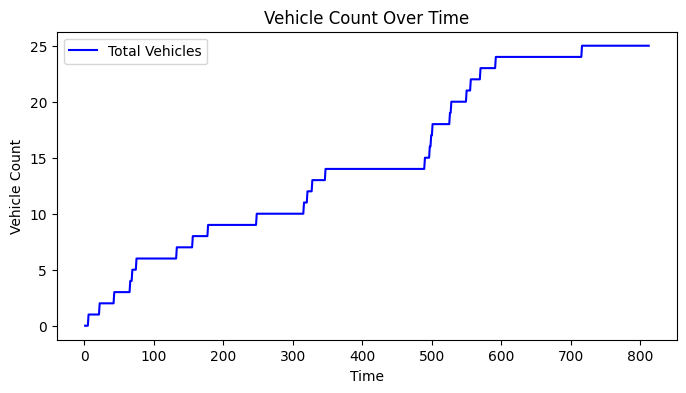

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(time_intervals, vehicle_count_log, label='Total Vehicles', color='blue')
plt.xlabel('Time')
plt.ylabel('Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.legend()
plt.show()


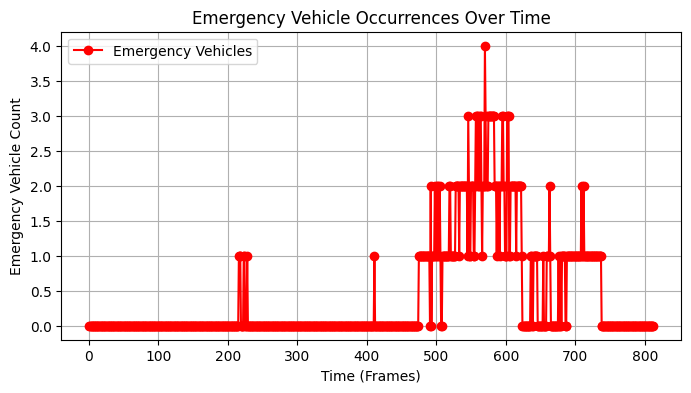

In [5]:
plt.figure(figsize=(8, 4))

# Plot emergency vehicle count over time
plt.plot(time_intervals, emergency_count_log, color='red', marker='o', linestyle='-', label='Emergency Vehicles')

plt.xlabel('Time (Frames)')
plt.ylabel('Emergency Vehicle Count')
plt.title('Emergency Vehicle Occurrences Over Time')
plt.legend()
plt.grid(True)

plt.show()

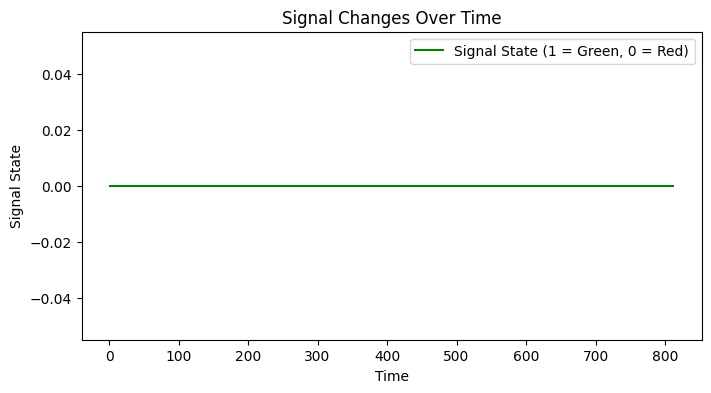

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(time_intervals, signal_change_log, label='Signal State (1 = Green, 0 = Red)', color='green')
plt.xlabel('Time')
plt.ylabel('Signal State')
plt.title('Signal Changes Over Time')
plt.legend()
plt.show()
